In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit atr, stop loss atr
# Variables :
# time - 15m, 1h
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# tp atr - 4, 6
# sl atr - 3, 5
# sl - Close, Low

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1671366861000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [5]:
sl_atr = 2
tp_atr = 8
kd_dir = 'Up'

In [6]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [7]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

                Close_Time     Open    Close     High      Low      Volume
0      2022-12-18 20:59:59  1183.11  1181.17  1183.96  1180.81   3925.0671
1      2022-12-18 21:14:59  1181.16  1180.57  1181.37  1180.11   2932.6802
2      2022-12-18 21:29:59  1180.57  1180.28  1181.00  1180.11   2475.6827
3      2022-12-18 21:44:59  1180.28  1179.06  1180.55  1177.38   3659.4905
4      2022-12-18 21:59:59  1179.07  1178.67  1179.48  1178.41    723.3260
...                    ...      ...      ...      ...      ...         ...
15704  2023-05-31 12:14:59  1897.71  1896.38  1897.89  1894.99   1262.1349
15705  2023-05-31 12:29:59  1896.37  1894.80  1898.53  1893.81   4942.5156
15706  2023-05-31 12:44:59  1894.79  1890.31  1895.59  1889.04   7985.1005
15707  2023-05-31 12:59:59  1890.31  1874.01  1891.31  1870.00  18228.7497
15708  2023-05-31 13:14:59  1874.01  1871.15  1875.62  1861.76  16359.9683

[15709 rows x 6 columns]


In [8]:
df = rawdf.copy()

In [9]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
    for i in (50, 100):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()        
        
# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    for i in (7, 14, 21):
        df['rsi_'+str(i)] = ta.momentum.RSIIndicator(df['Close'], window = i).rsi()

# adx
    df['adx'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=14).adx()
        
# kd
    kd_int = 17
    d_int = 5
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [10]:
indicators(df, kd_dir)
print(df)

                Close_Time     Open    Close     High      Low      Volume  \
0      2022-12-18 20:59:59  1183.11  1181.17  1183.96  1180.81   3925.0671   
1      2022-12-18 21:14:59  1181.16  1180.57  1181.37  1180.11   2932.6802   
2      2022-12-18 21:29:59  1180.57  1180.28  1181.00  1180.11   2475.6827   
3      2022-12-18 21:44:59  1180.28  1179.06  1180.55  1177.38   3659.4905   
4      2022-12-18 21:59:59  1179.07  1178.67  1179.48  1178.41    723.3260   
...                    ...      ...      ...      ...      ...         ...   
15704  2023-05-31 12:14:59  1897.71  1896.38  1897.89  1894.99   1262.1349   
15705  2023-05-31 12:29:59  1896.37  1894.80  1898.53  1893.81   4942.5156   
15706  2023-05-31 12:44:59  1894.79  1890.31  1895.59  1889.04   7985.1005   
15707  2023-05-31 12:59:59  1890.31  1874.01  1891.31  1870.00  18228.7497   
15708  2023-05-31 13:14:59  1874.01  1871.15  1875.62  1861.76  16359.9683   

            ema_50      ema_100         bb_u         bb_m      

C:\Users\yenju\Anaconda3\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\yenju\Anaconda3\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [11]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
#     df['c3'] = False
    for i, row in df.iterrows():
        df['c1'] = (df['rsi_7'].shift(1) <= df['rsi_21'].shift(1)) & (df['rsi_7'] > df['rsi_21'])
#         df['c2'] = (df['rsi_14'].shift(1) <= df['rsi_21'].shift(1)) & (df['rsi_14'] > df['rsi_21'])
#         df['c3'] = df['adx'] >= 20
#         if i >= 5:
#             if ((df.loc[i-5:i-1, 'adx'] <= 20).any()) & (df.loc[i, 'adx'] >= 20):
#                 df.loc[i, 'c3'] = True
        


    # 條件達成
    df['signal'] = False
    df.loc[df.c1, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [12]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_50,ema_100,bb_u,bb_m,...,rsi_7,rsi_14,rsi_21,adx,slow_k,slow_d,kd_cross,c1,signal,openbuy
0,2022-12-18 20:59:59,1183.11,1181.17,1183.96,1180.81,3925.0671,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False
1,2022-12-18 21:14:59,1181.16,1180.57,1181.37,1180.11,2932.6802,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False
2,2022-12-18 21:29:59,1180.57,1180.28,1181.00,1180.11,2475.6827,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False
3,2022-12-18 21:44:59,1180.28,1179.06,1180.55,1177.38,3659.4905,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False
4,2022-12-18 21:59:59,1179.07,1178.67,1179.48,1178.41,723.3260,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15704,2023-05-31 12:14:59,1897.71,1896.38,1897.89,1894.99,1262.1349,1901.512679,1901.126508,1910.658942,1901.397667,...,42.591201,42.980217,44.170759,33.110596,52.933450,54.203152,False,False,False,True
15705,2023-05-31 12:29:59,1896.37,1894.80,1898.53,1893.81,4942.5156,1901.249436,1901.001231,1910.613608,1901.100333,...,37.226566,40.513569,42.521861,34.375469,46.015762,53.852890,False,False,False,False
15706,2023-05-31 12:44:59,1894.79,1890.31,1895.59,1889.04,7985.1005,1900.820439,1900.789523,1910.557333,1900.545667,...,26.260349,34.460992,38.260147,36.151896,26.357268,47.959720,False,False,False,False
15707,2023-05-31 12:59:59,1890.31,1874.01,1891.31,1870.00,18228.7497,1899.769049,1900.259235,1912.529754,1899.323000,...,11.683481,21.754699,27.683930,39.036118,10.799892,38.972588,False,False,False,False


In [13]:
entry_df = conditions(df).copy()
entry_df.to_csv('check.csv')
in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'openbuy'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'High'] >= take_profit):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['openbuy'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]

print(entry_df)

                Close_Time     Open    Close     High      Low      Volume  \
26     2022-12-19 03:29:59  1178.77  1182.13  1182.75  1178.00   1640.6478   
27     2022-12-19 03:44:59  1182.13  1183.40  1183.41  1181.12    884.3290   
37     2022-12-19 06:14:59  1182.44  1186.08  1186.08  1181.99   1648.7390   
38     2022-12-19 06:29:59  1186.07  1185.78  1186.89  1185.32   1471.3376   
46     2022-12-19 08:29:59  1186.09  1192.23  1192.27  1185.24   2880.1377   
...                    ...      ...      ...      ...      ...         ...   
15701  2023-05-31 11:29:59  1895.21  1897.04  1897.17  1894.99   1229.2595   
15702  2023-05-31 11:44:59  1897.05  1897.02  1897.71  1896.68   1022.0516   
15703  2023-05-31 11:59:59  1897.02  1897.71  1897.95  1896.81    913.2250   
15704  2023-05-31 12:14:59  1897.71  1896.38  1897.89  1894.99   1262.1349   
15707  2023-05-31 12:59:59  1890.31  1874.01  1891.31  1870.00  18228.7497   

            ema_50      ema_100         bb_u         bb_m  ... 

In [14]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'rsi_7', 'rsi_14', 'rsi_21', 'ema_50', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Open']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


    Profit      Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  6940.72  2595.98      912.29   -136.51         21      31602.22  219.63%   

  Win_Rate  
0   31.14%  

               Close_Time     Open    Close     High      Low      rsi_7  \
0     2022-12-19 03:44:59  1182.13  1183.40  1183.41  1181.12  68.197809   
1     2022-12-19 06:29:59  1186.07  1185.78  1186.89  1185.32  64.964723   
2     2022-12-19 08:44:59  1192.24  1189.47  1195.00  1189.00  55.870703   
3     2022-12-19 09:44:59  1191.87  1191.13  1193.67  1190.03  58.527382   
4     2022-12-19 11:14:59  1183.76  1179.64  1184.47  1176.50  25.570114   
...                   ...      ...      ...      ...      ...        ...   
1912  2023-05-31 08:59:59  1903.39  1904.96  1905.27  1902.70  59.955523   
1913  2023-05-31 10:14:59  1903.21  1891.75  1903.21  1884.29  21.467176   
1914  2023-05-31 11:44:59  1897.05  1897.02  1897.71  1896.68  44.678896   
1915  2023-05-31 12:14:59  1897.71  1896.38  1897.89  

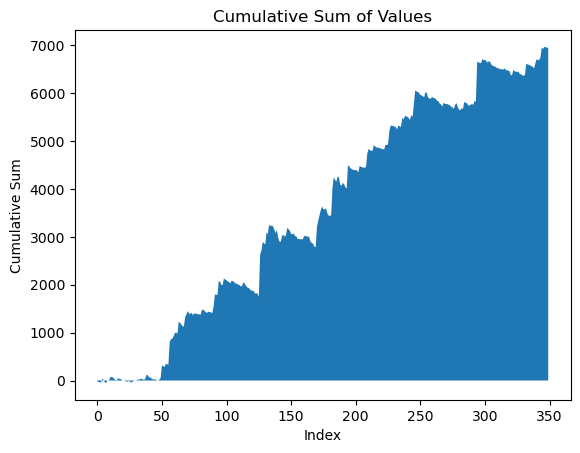

[-22.023679999999942, -30.930485000000402, -36.53264500000034, -42.07798500000073, 44.85756554999879, 0.5955955499989898, -42.74437444999843, -50.21221444999869, 6.153407900001554, -12.600267099998327, 75.80488220000444, 70.57277720000455, 67.49427720000448, 36.753537200005326, 10.687377200005166, 4.190497200005088, 46.24557315000476, 35.53557315000483, 32.307108150004915, 6.549383150005028, 1.749588150005068, -4.357116849995019, -11.315001849994843, -28.061316849994984, -10.613601849992492, -15.93189184999239, -38.24613684999309, -39.96111684999326, 12.376458850007012, 8.155688850007095, -5.547261149993023, 20.66056570000713, 16.705510700007466, 26.117493600007407, 40.07633635000751, 21.988886350008126, 18.473626350007997, 25.5702013500079, 116.91141395000852, 110.79772895000869, 68.33566895000806, 62.12476895000797, 41.44090395000846, 24.92361895000952, 22.050763950009365, 24.38085895000967, 7.4854439500099765, -2.8263210499906943, 17.06559210000991, 52.44222680000994, 310.9194068000

In [15]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

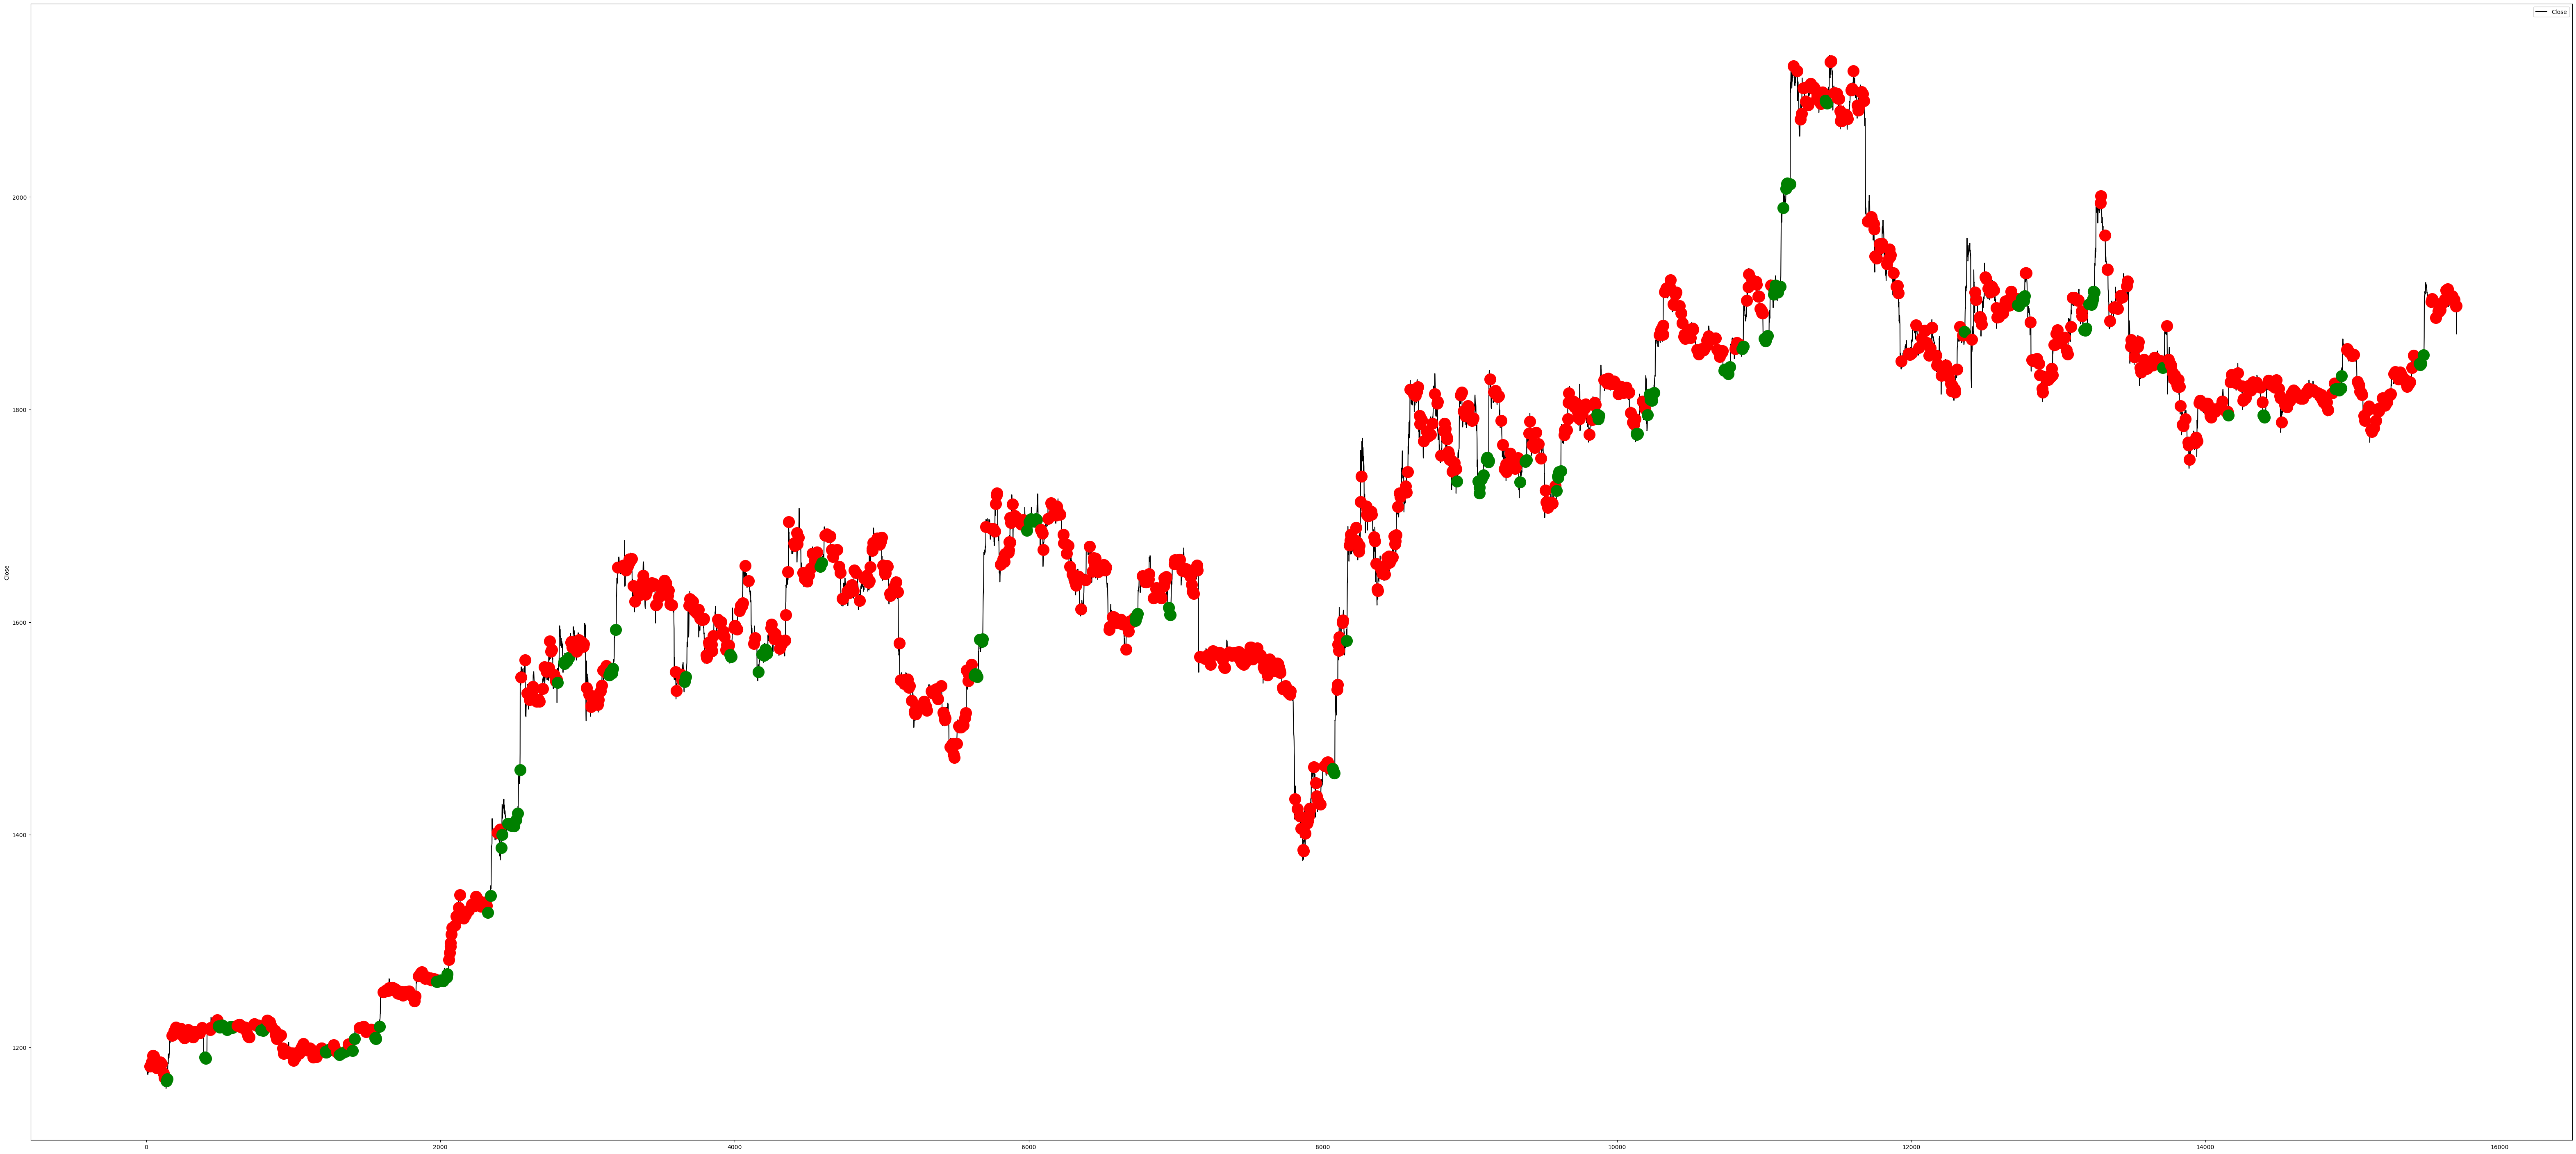

In [16]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位